# Import Statements and Loading Data

In [1]:
#Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import textwrap
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import gc

RANDOM_SEED = 42

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-07-14 14:27:09.878348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 14:27:09.892123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 14:27:09.892146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 14:27:09.902382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 14:27:10.520474: W tensorflow/compiler/tf

Num GPUs Available:  1


2024-07-14 14:27:12.824682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 14:27:12.833168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 14:27:12.839909: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
## Data from Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# train = pd.read_csv("drive/MyDrive/266Project/train-3.csv")
# test = pd.read_csv("drive/MyDrive/266Project/test.csv")
# validation = pd.read_csv("drive/MyDrive/266Project/validation.csv")


In [3]:
## Data locally
train = pd.read_csv("data/medal_train.csv")
test = pd.read_csv("data/medal_test.csv")
validation = pd.read_csv("data/medal_val.csv")
print(len(train))
print(len(test))
print(len(validation))


3000000
1000000
1000000


# Exploratory Data Analysis and Data Cleaning

In [4]:
#example of text
train.text[0]


'velvet antlers vas are commonly used in traditional chinese medicine and invigorant and contain many PET components for health promotion the velvet antler peptide svap is one of active components in vas based on structural study the svap interacts with tgfÎ² receptors and disrupts the tgfÎ² pathway we hypothesized that svap prevents cardiac fibrosis from pressure overload by blocking tgfÎ² signaling SDRs underwent TAC tac or a sham operation T3 one month rats received either svap mgkgday or vehicle for an additional one month tac surgery induced significant cardiac dysfunction FB activation and fibrosis these effects were improved by treatment with svap in the heart tissue tac remarkably increased the expression of tgfÎ² and connective tissue growth factor ctgf ROS species C2 and the phosphorylation C2 of smad and ERK kinases erk svap inhibited the increases in reactive oxygen species C2 ctgf expression and the phosphorylation of smad and erk but not tgfÎ² expression in cultured cardi

In [5]:
#looking at abbreviation
train.text[0].split()[63]


'TAC'

In [6]:
#looking at structure of location column
train['location'].value_counts()


location
[0]       84375
[1]       38055
[3]       33892
[6]       33524
[5]       33440
          ...  
[613]         1
[583]         1
[577]         1
[1037]        1
[637]         1
Name: count, Length: 767, dtype: int64

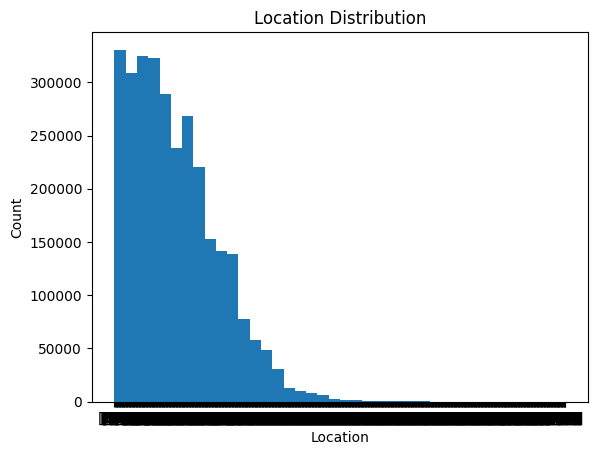

In [7]:
#plotting location
plt.hist(train['location'], bins = 40)
plt.title('Location Distribution')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()


In [8]:
# How many different labels are there?
print(len(train['label'].unique()))


22555


In [9]:
#cleaning locations and labels
max_length = 200
max_location = max_length - 3 # minus [CLS] and [SEP] tokens added and index offset

def process_location(location):
    return list(map(int, eval(location)))[0]

def process_label(label):
    return eval(label)[0]

# Reading and processing training data
train_df = pd.read_csv('data/medal_train.csv')
train_df['location'] = train_df['location'].map(process_location)
train_df['label'] = train_df['label'].map(process_label)
train_df['abbreviation'] = train_df.apply(lambda row: row['text'].split()[row['location']], axis=1)
train_df = train_df[train_df['location'] <= max_location]

# Reading and processing validation data
val_df = pd.read_csv('data/medal_val.csv')
val_df['location'] = val_df['location'].map(process_location)
val_df['label'] = val_df['label'].map(process_label)
val_df['abbreviation'] = val_df.apply(lambda row: row['text'].split()[row['location']], axis=1)
val_df = val_df[val_df['location'] <= max_location]

# Reading and processing test data
test_df = pd.read_csv('data/medal_test.csv')
test_df['location'] = test_df['location'].map(process_location)
test_df['label'] = test_df['label'].map(process_label)
test_df['abbreviation'] = test_df.apply(lambda row: row['text'].split()[row['location']], axis=1)
test_df = test_df[test_df['location'] <= max_location]

del train
del validation
del test

gc.collect()

train_df.head()

,Unnamed: 0,abstract_id,text,location,label,abbreviation
0,0,14145090,velvet antlers vas are commonly used in tradit...,63,transverse aortic constriction,TAC
1,1,1900667,the clinical features of our cases demonstrate...,85,hodgkins lymphoma,HD
2,2,8625554,ceftobiprole bpr is an investigational cephalo...,90,methicillinsusceptible s aureus,MSSA
3,3,8157202,we have taken a basic biologic RPA to elucidat...,26,parathyroid hormonerelated protein,PTHrP
4,4,6784974,lipoperoxidationderived aldehydes for example ...,157,lipoperoxidation,LPO


In [10]:
NUM_ABBREVIATIONS = 10 # To get full dataset: 5798
random.seed(RANDOM_SEED)

abbreviation_subset = random.sample(list(train_df.abbreviation.unique()), NUM_ABBREVIATIONS)

In [11]:
train_subset = train_df[train_df['abbreviation'].isin(abbreviation_subset)]
test_subset = test_df[test_df['abbreviation'].isin(abbreviation_subset)]
validation_subset = val_df[val_df['abbreviation'].isin(abbreviation_subset)]

print(len(train_subset))
print(len(validation_subset))
print(len(test_subset))

4753
1578
1575


In [12]:
label_names = sorted(train_subset.label.unique())
print(f"Size: {len(label_names)}", label_names)


Size: 37 ['active wakefulness', 'active waking', 'anterior wall', 'ash weight', 'desimipramine', 'desmethylimipramine', 'diabetic muscle infarction', 'dibutylnitrosamine', 'doppler myocardial imaging', 'downbeat nystagmus', 'dry matter intake', 'ecarin clotting time', 'electrochemotherapy', 'electroconvulsive therapy', 'electroconvulsive treatment', 'endocurietherapy', 'glomerular volume', 'graft', 'interaural level differences', 'interstitial lung diseases', 'narcissistic personality disorder', 'nasal potential difference', 'nndibutylnitrosamine', 'nocturnal paroxysmal dystonia', 'normal protein diet', 'paired filtration dialysis', 'pelvic floor dysfunction', 'perfluorodecalin', 'photon flux density', 'proteinfree diet', 'sulfated cholecystokinin octapeptide', 'uridine', 'urinary retention', 'utilization review', 'vein grafts', 'ventriculography', 'vestibular ganglion']


# BERT Base Model


In [13]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)


2024-07-14 14:30:09.662727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 14:30:09.677894: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 14:30:09.687296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
# tokenize the subset dataset, truncate at `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
def tokenize(text):
    return bert_tokenizer(
        list(text),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors='tf',
    )

train_encodings = tokenize(train_subset.text)
valid_encodings = tokenize(validation_subset.text)
test_encodings = tokenize(test_subset.text)


In [15]:
def get_abbrev_token_positions(text, abbrev):
    """
    Takes text and abbreviation and finds the start and end index of the
    tokenized representation of that abbreviation in the text
    """
    tokenized_text = bert_tokenizer.tokenize(text)
    tokenized_abbrev = bert_tokenizer.tokenize(abbrev)
    token_ids_text = bert_tokenizer.convert_tokens_to_ids(tokenized_text)
    token_ids_abbrev = bert_tokenizer.convert_tokens_to_ids(tokenized_abbrev)
    start = -1
    for i in range(len(token_ids_text) - len(token_ids_abbrev) + 1):
        if token_ids_text[i:i+len(token_ids_abbrev)] == token_ids_abbrev:
            start = i
            break

    if start == -1:
        raise ValueError(f"Abbreviation '{abbrev}' not found in text '{text}'")

    end = start + len(token_ids_abbrev) - 1
    return start, end


def extract_abbrev_positions_from_dataset(dataset):
    """Extracts all the start and end position of each abbreviation in a dataset"""
    start_positions = []
    end_positions = []
    for i, row in dataset.iterrows():
        start, end = get_abbrev_token_positions(row.text, row.abbreviation)
        # add 1 to account for CLS token at start
        # TODO: verify that this is actually needed and CLS token should be
        #   accounted for like this
        start_positions.append(start + 1)
        end_positions.append(end + 1)

    return start_positions, end_positions


train_start_positions, train_end_positions = extract_abbrev_positions_from_dataset(train_subset)
valid_start_positions, valid_end_positions = extract_abbrev_positions_from_dataset(validation_subset)
test_start_positions, test_end_positions = extract_abbrev_positions_from_dataset(test_subset)


In [16]:
def encode_labels(labels):
    return [label_names.index(label) for label in labels]


train_labels = encode_labels(train_subset.label)
valid_labels = encode_labels(validation_subset.label)
test_labels = encode_labels(test_subset.label)

In [17]:
# show original text
example_index = 31
print("Text:\n", "\n".join(textwrap.wrap(list(train_subset.text)[example_index])), "\n")
print("Label:", train_labels[example_index], label_names[train_labels[example_index]])

# encoded abbreviation span decoded back to abbreviation text
abbrev_encodings = train_encodings.input_ids[example_index][train_start_positions[example_index]:train_end_positions[example_index]+1]
print("Abbreviation tokens:", bert_tokenizer.decode(abbrev_encodings))


Text:
 flow limitation during pressuredriven expiration in liquidfilled lungs
was examined in intact euthanized new zealand WG rabbits the aim of
this study was to further characterize expiratory flow limitation
during gravitational drainage of perfluorocarbon liquids from the
lungs and to study the effect of perfluorocarbon type and negative
mouth pressure on this phenomenon four different PFCs pp PFD PFOB and
fc were used to examine the effects of density and kinematic viscosity
on volume recovered and Vmax it was demonstrated that flow limitation
occurs during gravitational drainage when the airway pressure is or cm
ho and that this critical value of pressure did not depend on mouth
pressure or perfluorocarbon type the perfluorocarbon properties affect
the volume recovered Vmax and the time to drain with the most viscous
perfluorocarbon PFD taking the longest time to drain and resulting in
lowest Vmax perfluorooctylbromide resulted in the highest recovered
volume the findings of thi

In [30]:
class ExtractAbbreviationHiddenStates(tf.keras.layers.Layer):
    """
    Custom layer that extracts abbreviation embeddings from BERT
    hidden layer state and position inputs
    """
    def call(self, inputs):
        last_hidden_state, start_abbrev_token_positions, end_abbrev_token_positions = inputs

        batch_size = tf.shape(last_hidden_state)[0]
        max_length = tf.shape(last_hidden_state)[1]
        hidden_size = tf.shape(last_hidden_state)[2]

        span_hidden_states = tf.TensorArray(tf.float32, size=batch_size)

        for i in tf.range(batch_size):
            start_pos = start_abbrev_token_positions[i, 0]
            end_pos = end_abbrev_token_positions[i, 0]

            # TODO: training fails without this... when do we expect start or end position to be
            #   greater than 199?
            start_pos = tf.clip_by_value(start_pos, 0, max_length - 1)
            end_pos = tf.clip_by_value(end_pos, 0, max_length - 1)

            span_hidden_state = last_hidden_state[i, start_pos:end_pos + 1, :]
            span_length = end_pos - start_pos + 1

            # pad to the maximum length
            padded_span_hidden_state = tf.pad(span_hidden_state, [[0, max_length - span_length], [0, 0]])
            span_hidden_states = span_hidden_states.write(i, padded_span_hidden_state)

        return span_hidden_states.stack()


def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = len(label_names),
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the pooled abbreviation
    token embeddings for classification purposes.
    """
    tf.keras.backend.clear_session()
    tf.random.set_seed(RANDOM_SEED)

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')
    start_abbrev_token_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='start_abbreviation_token_positions_layer')
    end_abbrev_token_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='end_abbreviation_token_positions_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_model = TFBertModel.from_pretrained(checkpoint, from_pt=True)
    bert_model.trainable = True

    bert_out = bert_model(bert_inputs)

    last_hidden_state = bert_out.last_hidden_state

    span_hidden_states = ExtractAbbreviationHiddenStates()([last_hidden_state, start_abbrev_token_positions, end_abbrev_token_positions])

    pooled_output = tf.reduce_mean(span_hidden_states, axis=1)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(pooled_output)

    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask, start_abbrev_token_positions, end_abbrev_token_positions],
        outputs=[classification],
    )

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model


In [31]:
model = create_bert_multiclass_model()
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 200)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 200)]                0         []                            
 tLayer)                                                                                      

In [32]:
train_inputs = [
    np.array(train_encodings.input_ids),
    np.array(train_encodings.token_type_ids),
    np.array(train_encodings.attention_mask),
    np.array(train_start_positions),
    np.array(train_end_positions),
]
valid_inputs = [
    np.array(valid_encodings.input_ids),
    np.array(valid_encodings.token_type_ids),
    np.array(valid_encodings.attention_mask),
    np.array(valid_start_positions),
    np.array(valid_end_positions)
]
history = model.fit(
    train_inputs,
    np.array(train_labels),
    validation_data=(valid_inputs, np.array(valid_labels)),
    batch_size=16,
    shuffle=True,
    verbose=1,
    epochs=5,
)

model.save('models/20240714_base_bert_ft')
embedding_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer('tf_bert_model').output.last_hidden_state
)
embedding_model.save('models/20240714_base_bert_ft_embedding')

Epoch 1/5
114/298 [==========>...................] - ETA: 34s - loss: 3.4957 - accuracy: 0.4967

KeyboardInterrupt: 

In [ ]:
test_inputs = [
    np.array(test_encodings.input_ids),
    np.array(test_encodings.token_type_ids),
    np.array(test_encodings.attention_mask),
    np.array(test_start_positions),
    np.array(test_end_positions),
]

test_loss, test_accuracy = model.evaluate(test_inputs)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

predictions = model.predict(test_inputs)
y_pred = np.argmax(predictions, axis=-1)
y_true = test_labels


516/516 [==============================] - 6s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 0.0
516/516 [==============================] - 63s 111ms/step


In [ ]:
sample = np.random.randint(0, test_encodings.input_ids.shape[0])
print("Sample:", sample)
print("First X Test:\n", bert_tokenizer.convert_tokens_to_string(bert_tokenizer.convert_ids_to_tokens(test_inputs[0][sample])))
print("First Y True:\n", label_names[y_true[sample]])
print("First Y Pred:\n", label_names[y_pred[sample]])


Sample: 11726
First X Test:
 [CLS] the method is suggested to isolate simultaneously microsomes and PMs of neuroblastoma s n cells by means of differential centrifugation in the step density gradient of percollficoll with a high degree of purification determined from the activity of marker enzymes acetyl cholinesterase nakatpase alkali phosphatase glucosephosphatase succinatedehydrogenase acid phosphatase as well as from the content of dna and rna and with a sufficiently high protein yield the purified fractions of microsomes and plasma membranes are established to contain no phosphatidyl glycerol and cardiolipinsafety markers of mitochondrial membrane purification a degree of separation of microsomes PMs and proteins dissolved in cytosol may be estimated by the activity of the cholesterolsynthesizing system of enzymes with the use of steroltransferring protein [SEP]
First Y True:
 plasma membranes
First Y Pred:
 plasma membranes
